### Import TensorFlow

In [ ]:
import numpy as np
import zipfile
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
import pathlib
dataset_url = "file:///content/FMD_extended.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

144810508/144810508 [==============================] - 0s 0us/step


In [ ]:
archive

'/root/.keras/datasets/FMD_extended.zip'

In [ ]:
os.path.getsize(archive)

144810508

In [ ]:
with zipfile.ZipFile(archive,"r") as zip_ref:
    zip_ref.extractall("targetdir")

In [ ]:
data_dir = pathlib.Path('/content/targetdir/FMD_extended/')

In [ ]:
data_dir

PosixPath('/content/targetdir/FMD_extended')

In [ ]:
os.path.getsize(data_dir)

4096

In [ ]:
for item in data_dir.glob("*"):
  print(item.name)

mask
image


In [ ]:
image_count = len(list(data_dir.glob('image/fabric/*.jpg')))
print(image_count)

146


In [ ]:
batch_size = 32
img_height = 380
img_width = 380

In [ ]:
images = data_dir / 'image'
images

PosixPath('/content/targetdir/FMD_extended/image')

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  images,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 1474 files belonging to 10 classes.
Using 1106 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  images,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size= 1
  )

Found 1474 files belonging to 10 classes.
Using 368 files for validation.


In [ ]:
train_ds = train_ds.shuffle(buffer_size=200)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
model= tf.keras.models.load_model("effnetV2B0_86_.h5")

In [ ]:
_, accuracy,_  = model.evaluate(val_ds)
print("Test accuracy:" , accuracy)

368/368 [==============================] - 16s 14ms/step - loss: 0.5362 - accuracy: 0.8668 - sparse_top_k_categorical_accuracy: 0.9891
Test accuracy: 0.866847813129425


In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

baseline_tflite = "unquantized.tflite"
with open(baseline_tflite, 'wb') as f:
  f.write(tflite_model)
print("Size of the unquantized tflite model: %.2f Mb" % (os.path.getsize(baseline_tflite)/float(2**20)))


Size of the unquantized tflite model: 22.37 Mb


In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 2.9 MB/s eta 0:00:00


In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 32
epochs = 200
num_images = 1106
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
# pruning_params = {
#       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                final_sparsity=0.65,
#                                                                begin_step=300,
#                                                                end_step=end_step, frequency=50)
# }
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
  }


callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

def apply_pruning_to_layer(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

pruned_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_layer,
)
#pruned_model = prune_low_magnitude(model, **pruning_params)

# Use smaller learning rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

pruned_model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'])

Epoch 1/50
35/35 [==============================] - 73s 444ms/step - loss: 0.3274 - accuracy: 0.8852 - val_loss: 0.5322 - val_accuracy: 0.8668
Epoch 2/50
35/35 [==============================] - 16s 339ms/step - loss: 0.3022 - accuracy: 0.8924 - val_loss: 0.5113 - val_accuracy: 0.8696
Epoch 3/50
35/35 [==============================] - 19s 370ms/step - loss: 0.5583 - accuracy: 0.8192 - val_loss: 3.8267 - val_accuracy: 0.3179
Epoch 4/50
35/35 [==============================] - 18s 359ms/step - loss: 1.5994 - accuracy: 0.5081 - val_loss: 1.7101 - val_accuracy: 0.5109
Epoch 5/50
35/35 [==============================] - 17s 378ms/step - loss: 1.3638 - accuracy: 0.5913 - val_loss: 1.2491 - val_accuracy: 0.6196
Epoch 6/50
35/35 [==============================] - 18s 364ms/step - loss: 1.2663 - accuracy: 0.6130 - val_loss: 1.0388 - val_accuracy: 0.6603
Epoch 7/50
35/35 [==============================] - 16s 340ms/step - loss: 1.2132 - accuracy: 0.6221 - val_loss: 0.9689 - val_accuracy: 0.6875

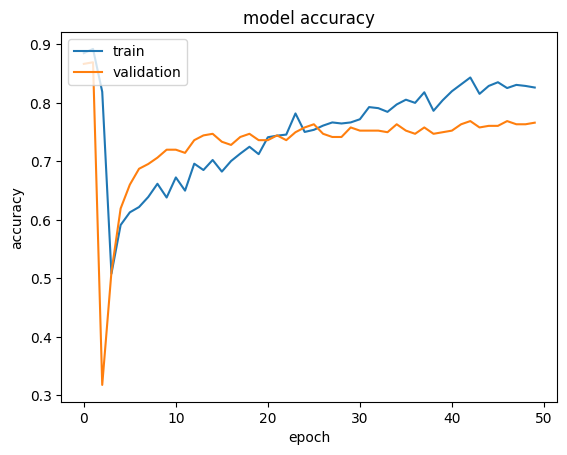

In [ ]:
# Fine-tune model
hist = pruned_model.fit(
  train_ds,
  epochs=50,
  batch_size=32,
  validation_data=val_ds,
  callbacks=callbacks)
plot_hist(hist)

In [ ]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )

In [ ]:
# stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# print_model_weights_sparsity(stripped_pruned_model)

In [ ]:
_, acc = pruned_model.evaluate(val_ds)
print(acc)

368/368 [==============================] - 6s 16ms/step - loss: 0.8433 - accuracy: 0.7663
0.7663043737411499


In [ ]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [ ]:

from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}


def apply_clustering_to_layer(layer):
  #if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
  if layer.trainable_weights:
    return cluster_weights(layer, **clustering_params)
  return layer

sparsity_clustered_model = tf.keras.models.clone_model(
    stripped_pruned_model,
    clone_function=apply_clustering_to_layer,
)

sparsity_clustered_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print('Train sparsity preserving clustering model:')
sparsity_clustered_model.fit(train_ds,epochs=10, validation_data=val_ds)

Train sparsity preserving clustering model:
Epoch 1/10
35/35 [==============================] - 31s 409ms/step - loss: 0.8168 - accuracy: 0.7315 - val_loss: 1.0178 - val_accuracy: 0.7255
Epoch 2/10
35/35 [==============================] - 16s 336ms/step - loss: 0.6695 - accuracy: 0.7821 - val_loss: 0.9536 - val_accuracy: 0.7174
Epoch 3/10
35/35 [==============================] - 18s 367ms/step - loss: 0.6715 - accuracy: 0.7893 - val_loss: 0.8389 - val_accuracy: 0.7527
Epoch 4/10
35/35 [==============================] - 16s 345ms/step - loss: 0.5974 - accuracy: 0.7975 - val_loss: 0.8936 - val_accuracy: 0.7174
Epoch 5/10
35/35 [==============================] - 16s 338ms/step - loss: 0.5062 - accuracy: 0.8318 - val_loss: 1.0589 - val_accuracy: 0.7147
Epoch 6/10
35/35 [==============================] - 18s 352ms/step - loss: 0.4970 - accuracy: 0.8210 - val_loss: 1.0418 - val_accuracy: 0.7147
Epoch 7/10
35/35 [==============================] - 17s 357ms/step - loss: 0.5136 - accuracy: 0.83

In [ ]:
_, acc1 = sparsity_clustered_model.evaluate(val_ds)
print(acc1)

368/368 [==============================] - 7s 18ms/step - loss: 1.0314 - accuracy: 0.7364
0.7364130616188049


In [ ]:
stripped_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

In [ ]:
#Both activations and weights are quantized to 8-bit integers

converter = tf.lite.TFLiteConverter.from_keras_model(stripped_clustered_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

#train_ds_images = tf.data.Dataset.from_tensor_slices((train_ds)).batch(1)
def representative_data_gen():
  for image,label in train_ds.take(4):
    yield [image]
converter.representative_dataset = representative_data_gen


In [ ]:
tflite_model_quantized = converter.convert()

model_quant_tflite_file = "materialdetection_quant1.tflite"
with open(model_quant_tflite_file, 'wb') as f:
  f.write(tflite_model_quantized)
print("Size of the quantized tflite model: %.2f Mb" % (os.path.getsize(model_quant_tflite_file)/float(2**20)))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Size of the quantized tflite model: 6.80 Mb


In [ ]:
tflite_model_zip = "tflitemodel1.zip"

In [ ]:
import zipfile
with zipfile.ZipFile(tflite_model_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(model_quant_tflite_file)
print("Size of gzipped pruned clustered and quantized TFlite model: %.2f Mb" % (os.path.getsize(tflite_model_zip)/float(2**20)))
print("Size of gzipped pruned clustered and quantized TFlite model in Kb: %.2f Kb" % (os.path.getsize(tflite_model_zip)/float(2**10)))

Size of gzipped pruned clustered and quantized TFlite model: 3.88 Mb
Size of gzipped pruned clustered and quantized TFlite model in Kb: 3969.63 Kb


In [ ]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  accurate_count = 0
  #prediction_digits = []
  for test_image,test_label in val_ds:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.

   # test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    test_image =tf.cast(test_image, tf.uint8)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    #prediction_digits.append(digit)


  # lb=LabelBinarizer()
  # prediction_digits=lb.fit_transform(prediction_digits)

  # Compare prediction results with ground truth labels to calculate accuracy.

    if digit == test_label.numpy()[0]:
      accurate_count += 1


  # for index in range(len(prediction_digits)):
  #   if (prediction_digits[index] == test_labels[index]).all():
  #     accurate_count += 1
  accuracy = accurate_count * 1.0 / 368

  return "Accuracy: {}".format(accuracy)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quantized)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

Pruned and quantized TFLite test_accuracy: Accuracy: 0.7092391304347826


In [ ]:
from google.colab import files
files.download('/content/materialdetection_quant1.tflite')
files.download('/content/tflitemodel1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>